In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gekko import GEKKO

In [2]:
# create GEKKO model
m = GEKKO()

In [3]:
# constants
sm = 39.0 #maximal VO2
e0 = 2200 #starting level of energy
e_crit = 0.15 * e0 #critical level of energy, when sigma decreases
g = 9.81 #gravitational constant
distance = 1000 #final horizontal distance to cover [m]
mass = 75 #body mass

expected_finish_time = 150 #technical - expected solution
maximal_finish_time = 300 #technical - maximal finish time

In [4]:
# parameters
a = 60 * 50.65
b = 192.86 / 50.65

In [5]:
# time points [s]
nt = 101
tm = np.linspace(0,1,nt)
m.time = tm

In [6]:
# sigma data to create spline
E_data = np.linspace(0, e0, 1001)
sigma_data = sm * E_data/(e0 * e_crit) + 0.75 * sm * (1 - E_data/(e0 * e_crit))
sigma_data[E_data > e_crit] = sm

In [7]:
# slope data to create spline
x_data = np.linspace(0, distance, 500)
slope_data = np.array(250*[1/18 * np.pi] + 250 * [-1/18 * np.pi])

In [8]:
# Variables
v = m.Var(value=0.0, lb=0.0, ub=10.0) #velocity
E = m.Var(value=e0, lb=0.0) #energy
x = m.Var(value=0.0) #horizontal coordinate
t = m.Var(value=0.0, lb=0.0) #time representative
N = m.Var(value=0.0, lb=0.0) # oxidation rate
sigma = m.Var(value=sm, lb=0) #breathing rate
sigma_max = m.Var() #limit of sigma value
slope = m.Var(value=slope_data[0]) #slope

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

In [9]:
# FV - final time
tf = m.FV(value=expected_finish_time,lb=0.1,ub=maximal_finish_time)
tf.STATUS = 1

In [10]:
# MV
u = m.MV(value=0,lb=0,ub=12)
u.STATUS = 1

In [11]:
# energy decrease at the end
m.cspline(E, sigma_max, E_data, sigma_data, True)

# slope
m.cspline(x, slope, x_data, slope_data, True)

In [12]:
# equations
m.Equation(v.dt()==(u - g * m.sin(slope) - v/0.892)*tf)
m.Equation(E.dt()==(sigma - u*v + N * 4 * 4184 * 1/mass)*tf)
m.Equation(x.dt()==(v*m.cos(slope))*tf)
m.Equation(t.dt()==1)
m.Equation(N.dt()==((1/a * m.exp(-(t * tf + a*b)/a))*tf))
m.Equation(sigma<=sigma_max)
m.Equation((distance-x)*final<=0)

In [13]:
# objective
m.Minimize(tf)

In [14]:
m.options.IMODE = 6
m.options.MAX_ITER=1000
m.solve()

print('Final Time: ' + str(tf.value[0]))

apm 31.60.107.8_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            0
   Variables    :           13
   Intermediates:            0
   Connections  :            4
   Equations    :            8
   Residuals    :            8
 
 Number of state variables:           2001
 Number of total equations: -         1800
 Number of slack variables: -          200
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt,

  62  2.7713730e+04 1.53e+02 2.28e+16   3.8 1.48e+01  12.4 9.93e-01 5.71e-01h  1
  63  2.7713796e+04 1.50e+02 2.24e+16   3.1 6.33e+00  11.9 1.00e+00 1.87e-02h  1
  64  2.7674676e+04 7.79e-02 1.57e+15   3.1 6.17e+00  11.5 2.59e-04 1.00e+00h  1
  65  2.7674707e+04 1.56e-06 1.03e+11   5.2 1.34e-02  11.0 9.93e-01 1.00e+00f  1
  66  2.7680699e+04 8.51e+00 6.81e+09   3.3 3.39e-03  12.3 9.96e-01 9.96e-01s 22
  67  2.7677472e+04 1.67e+01 2.32e+09   3.4 2.50e-03  11.8 1.00e+00 8.61e-01h  1
  68  2.7681212e+04 1.66e+01 1.26e+09   2.7 5.65e-03  11.3 1.00e+00 1.00e+00h  1
  69  2.7691714e+04 2.01e+01 1.26e+09   2.0 1.70e-02  10.9 4.99e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.7709919e+04 5.99e+00 1.26e+09   1.3 1.39e-01  10.4 4.06e-01 2.50e-01h  3
  71  2.7725530e+04 3.36e+00 1.26e+09   0.6 1.91e-02  10.8 3.07e-01 1.00e+00h  1
  72  2.7761572e+04 1.90e+00 1.25e+09  -0.1 5.70e-02  10.3 7.69e-01 7.91e-01H  1
  73  2.7769089e+04 1.69e+00

 171  2.4133375e+04 4.76e+01 1.14e+05   4.5 8.07e+01    -  1.00e+00 1.00e+00s 22
 172  1.6576716e+04 1.32e+03 3.87e+11   4.4 6.89e+02    -  1.27e-01 7.99e-01f  1
 173  1.6584585e+04 1.32e+03 3.31e+13   3.6 5.47e-04  16.8 1.00e+00 9.59e-01h  1
 174  1.6646506e+04 1.27e+03 8.68e+13   3.9 4.13e-03  16.3 1.00e+00 1.00e+00f  1
 175  1.6917811e+04 1.06e+03 1.27e+14   4.2 1.81e-02  15.8 1.00e+00 1.00e+00f  1
 176  1.7818871e+04 1.23e+03 1.40e+14   4.5 6.01e-02  15.4 1.00e+00 1.00e+00f  1
 177  1.9268759e+04 1.89e+03 7.52e+13   4.4 1.43e-01  14.9 4.21e-01 1.00e+00H  1
 178  1.9198634e+04 1.84e+03 1.25e+12   3.7 7.61e-02  14.4 2.68e-01 1.00e+00H  1
 179  1.8533688e+04 1.48e+03 3.78e+12   3.0 4.43e-02  13.9 2.90e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.8438247e+04 1.26e+03 2.59e+12   2.3 8.61e-02  13.5 2.85e-01 1.00e+00h  1
 181  1.8461825e+04 1.26e+03 3.00e+12   2.3 1.31e+00  13.0 2.88e-01 4.31e-02f  1
 182  1.8461955e+04 1.26e+03

 263  1.6617141e+04 3.55e+03 2.31e+12   9.6 4.89e-08  19.7 9.90e-01 1.00e+00f  1
Scaling factors are invalid - setting them all to 1.
 264  2.0602259e+04 3.75e+03 3.88e+11   8.9 4.59e+03    -  4.54e-01 8.35e-01h  1
Scaling factors are invalid - setting them all to 1.
 265  2.2502626e+04 5.78e+02 1.05e+11   8.2 1.35e+03    -  6.86e-01 8.95e-01h  1
Scaling factors are invalid - setting them all to 1.
 266  2.2938619e+04 6.65e+01 1.01e+10   7.5 7.55e+02    -  9.09e-01 8.95e-01h  1
Scaling factors are invalid - setting them all to 1.
 267  2.3159023e+04 1.96e+00 2.23e+11   6.8 1.30e+03    -  8.85e-01 9.94e-01h  1
Scaling factors are invalid - setting them all to 1.
 268  2.3159023e+04 1.96e+00 2.51e+12   6.1 1.58e-07  19.2 9.96e-01 1.00e+00f  1
Scaling factors are invalid - setting them all to 1.
 269  2.3159030e+04 1.95e+00 2.62e+15   5.4 1.13e-01  18.7 5.73e-03 4.38e-03h  1
Scaling factors are invalid - setting them all to 1.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alp

 334r 1.9854341e+04 5.12e+02 1.00e+03   3.4 0.00e+00  14.8 0.00e+00 4.77e-07R 22
 335r 1.9818773e+04 8.09e+01 4.64e+03   2.3 6.68e+03    -  7.33e-01 7.58e-02f  1
 336  2.0017659e+04 1.08e+02 7.17e+02   3.4 7.58e+05    -  4.07e-03 2.12e-04f  1
 337  1.9624686e+04 3.39e+03 5.79e+03   3.4 1.45e+05    -  7.00e-02 4.80e-03f  1
 338  1.9347529e+04 3.36e+03 1.24e+04   3.4 4.29e+03    -  1.28e-01 1.31e-02f  1
 339  1.5875947e+04 7.60e+03 1.63e+04   3.4 3.37e+03    -  3.60e-01 2.52e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  1.2497959e+04 9.07e+03 2.76e+07   5.8 3.57e+05    -  9.90e-01 3.88e-03f  1
Scaling factors are invalid - setting them all to 1.
 341  1.3460734e+04 9.00e+03 2.71e+09   7.7 2.14e+06    -  9.90e-01 1.24e-02f  1
Scaling factors are invalid - setting them all to 1.
 342  1.5246177e+04 6.04e+03 1.80e+09   8.0 3.73e+02    -  1.45e-01 3.51e-01h  1
Scaling factors are invalid - setting them all to 1.
 343  2.1905989e+04 5.65e+02 3.

 417  1.6475811e+04 9.14e+02 8.61e+08   1.9 9.07e+00   6.4 1.33e-01 5.80e-02h  1
 418  1.6760161e+04 6.60e+02 3.49e+08   1.9 9.48e+00   5.9 2.14e-01 2.72e-01h  1
 419  1.7142722e+04 3.19e+02 5.46e+09   1.9 2.12e+01   6.4 1.67e-01 5.24e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420  1.7147915e+04 3.13e+02 1.87e+09   1.9 5.94e+01   7.7 1.80e-02 1.79e-02H  1
 421  1.7161617e+04 2.99e+02 1.79e+09   1.9 6.61e+00   7.2 1.49e-02 4.38e-02h  1
 422  1.7161948e+04 2.99e+02 1.79e+09   1.9 8.37e+00   6.7 9.18e-01 9.23e-04h  1
 423  1.7489599e+04 9.48e+01 5.63e+08   1.9 9.24e+00   6.3 4.57e-02 6.85e-01h  1
 424  1.7514008e+04 9.00e+01 5.35e+08   1.9 4.01e+00   5.8 9.31e-01 5.07e-02h  1
 425  1.7556411e+04 8.47e+01 5.02e+08   1.9 3.85e+00   5.3 8.66e-02 6.13e-02h  4
 426  1.7576376e+04 8.28e+01 4.90e+08   1.9 4.15e+00   4.8 1.56e-01 2.37e-02f  5
 427  1.7596972e+04 8.10e+01 4.79e+08   1.9 1.02e+01   4.4 7.27e-02 2.28e-02h  5
 428  1.7612633e+04 7.95e+01

 505  1.6868594e+04 2.27e+00 1.52e+01  -3.3 9.55e+00  -2.5 1.00e+00 9.90e-01h  1
Scaling factors are invalid - setting them all to 1.
 506  1.6746868e+04 2.58e+00 8.59e+02  -2.3 2.19e+01  -3.0 1.00e+00 2.65e-01h  1
 507  1.6616279e+04 3.25e+00 8.52e+02  -2.3 2.72e+01  -3.5 1.00e+00 2.64e-01h  1
 508  1.6597812e+04 3.37e+00 1.88e+02  -2.1 2.28e+00  -2.2 1.00e+00 9.93e-01h  1
 509  1.6585044e+04 1.96e+00 3.75e+03  -3.5 1.19e+00  -1.7 1.00e+00 5.87e-01h  1
Scaling factors are invalid - setting them all to 1.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510  1.6582670e+04 6.65e-01 6.37e+04  -2.2 1.15e+00  -1.3 1.00e+00 7.83e-01h  1
 511  1.6568165e+04 9.03e-01 8.48e+03  -8.2 1.57e+00  -1.8 5.83e-01 4.86e-01h  1
 512  1.6564262e+04 8.07e-01 6.21e+04  -2.6 3.42e+00  -2.3 1.00e+00 2.34e-01h  1
 513  1.6480614e+04 2.03e+00 6.78e+02  -2.8 7.00e+00  -2.8 1.00e+00 9.44e-01h  1
Scaling factors are invalid - setting them all to 1.
 514  1.6420831e+04 2.08e+00 1.

 587  1.4811363e+04 2.54e+02 6.93e+01  -3.4 5.22e+03    -  2.31e-01 7.45e-03h  1
 588  1.4837709e+04 2.34e+02 3.39e+01  -3.4 4.16e+03    -  1.05e-01 6.07e-01h  1
Scaling factors are invalid - setting them all to 1.
 589  1.4852172e+04 1.22e+02 1.45e+01  -3.4 3.03e+03    -  7.18e-01 5.59e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590  1.4859214e+04 6.24e+00 1.69e+00  -3.4 2.75e+01  -5.5 1.00e+00 1.00e+00h  1
 591  1.4862809e+04 4.45e+00 8.70e-02  -3.4 2.24e+03    -  1.00e+00 1.00e+00H  1
 592  1.4868219e+04 4.54e-01 3.90e-04  -3.4 5.24e+03    -  1.00e+00 1.00e+00h  1
 593  1.4842339e+04 8.28e-01 1.99e+00  -5.2 8.74e+03    -  9.72e-01 1.00e+00f  1
 594  1.4841792e+04 1.16e-01 7.21e-06  -5.2 9.36e+02    -  1.00e+00 1.00e+00h  1
 595  1.4841792e+04 1.21e-02 7.46e-07  -5.2 2.71e+00    -  1.00e+00 1.00e+00h  1
 596  1.4841293e+04 5.31e-03 2.35e-01  -6.6 2.02e+02    -  9.97e-01 9.85e-01h  1
 597  1.4841273e+04 3.70e-04 2.52e+00  -7.1 7.40e+00    

In [15]:
tm = tm * tf.value[0]

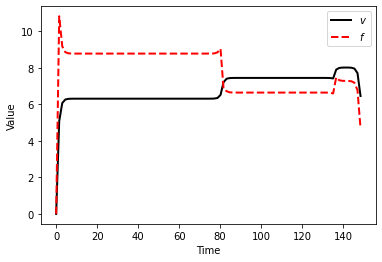

In [16]:
plt.figure(1)
plt.plot(tm,v.value,'k-',lw=2,label=r'$v$')
plt.plot(tm,u.value,'r--',lw=2,label=r'$f$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

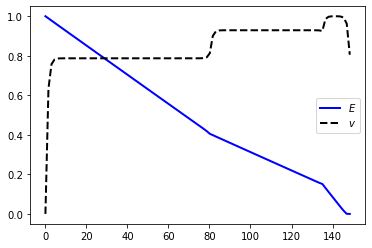

In [17]:
plt.figure(2)
plt.plot(tm,np.array(E.value)/max(E.value),'b-',lw=2,label=r'$E$')
plt.plot(tm,np.array(v.value)/max(v.value),'k--',lw=2,label=r'$v$')
plt.legend()
plt.show()

In [26]:
np.array(N.value) * 4 * 4164 * 1/mass

array([0.        , 0.00240644, 0.0048117 , 0.00721579, 0.0096187 ,
       0.01202044, 0.01442101, 0.01682041, 0.01921863, 0.02161569,
       0.02401157, 0.02640628, 0.02879983, 0.03119221, 0.03358341,
       0.03597345, 0.03836233, 0.04075003, 0.04313658, 0.04552195,
       0.04790616, 0.05028921, 0.0526711 , 0.05505182, 0.05743138,
       0.05980977, 0.06218701, 0.06456308, 0.066938  , 0.06931175,
       0.07168435, 0.07405579, 0.07642607, 0.07879519, 0.08116316,
       0.08352997, 0.08589562, 0.08826012, 0.09062347, 0.09298566,
       0.0953467 , 0.09770658, 0.10006531, 0.1024229 , 0.10477933,
       0.10713461, 0.10948874, 0.11184172, 0.11419355, 0.11654423,
       0.11889377, 0.12124215, 0.1235894 , 0.12593549, 0.12828044,
       0.13062425, 0.13296691, 0.13530843, 0.1376488 , 0.13998803,
       0.14232612, 0.14466307, 0.14699888, 0.14933354, 0.15166707,
       0.15399946, 0.15633071, 0.15866082, 0.16098979, 0.16331762,
       0.16564432, 0.16796989, 0.17029431, 0.17261761, 0.17493

In [23]:
# available VO2 depending on event time and altitude
# reference: Minetti

VO2_max = 55
event_time = 4 * 60 * 60
altitude = 1200

def fract_duration(event_time):
    return (940 - event_time/60) / 1000

def fract_altitude(alt):
    return 1 - 11.7 * 10**(-9) * alt**2 - 4.01 * 10**(-6) * alt

fract_duration = fract_duration(event_time)
fract_altitude = fract_altitude(altitude)

print(VO2_max * fract_duration * fract_altitude)

37.66609
